ECD Noiseless SSIM Stats: {'mean': np.float64(0.8991864061557174), 'std': np.float64(0.020826933861255784), 'quartile_25': np.float64(0.8865683078765869), 'quartile_50': np.float64(0.902549147605896), 'quartile_75': np.float64(0.9139414429664612), 'min': np.float64(0.7913756370544434), 'max': np.float64(0.9389474391937256)}
ECD Noiseless PSNR Stats: {'mean': np.float64(37.131455109909254), 'std': np.float64(4.527396284770613), 'quartile_25': np.float64(33.94242858886719), 'quartile_50': np.float64(37.80719757080078), 'quartile_75': np.float64(40.08678817749024), 'min': np.float64(23.242809295654297), 'max': np.float64(47.69609451293945)}
ECD Noiseless RMSE Stats: {'mean': np.float64(0.01603111452519671), 'std': np.float64(0.009427621638172757), 'quartile_25': np.float64(0.0099005736410617), 'quartile_50': np.float64(0.0128718242049217), 'quartile_75': np.float64(0.020085310563445), 'min': np.float64(0.0041228262707591), 'max': np.float64(0.0688429474830627)}
ECD Noisy SSIM Stats: {'mea

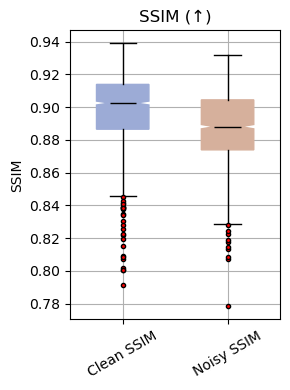

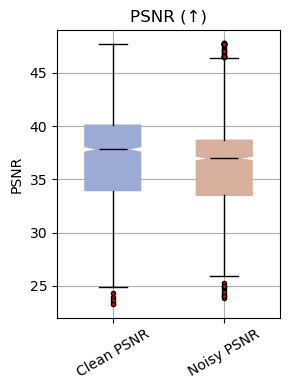

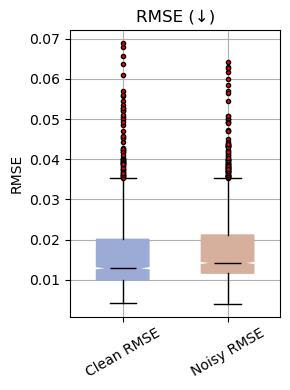

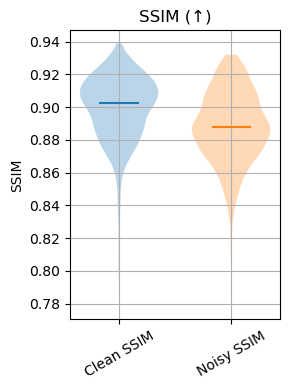

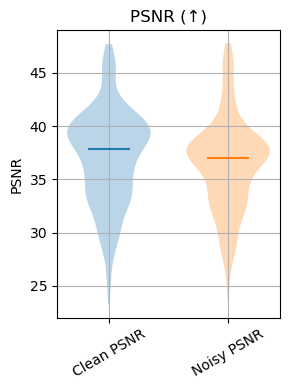

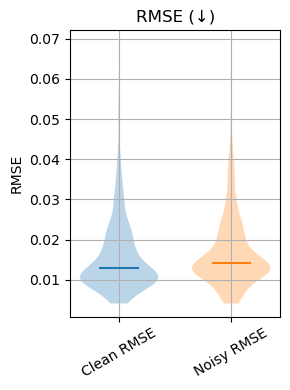

FileNotFoundError: [Errno 2] No such file or directory: '../data/step-epoch.csv'

In [1]:
# Some scripts to read CSVs exported from WandB and we'll plot them using matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_dir = '../data/'

def get_csv_data(file_path, x_col_name='Step', y_col_name='value', step_conversion: np.ndarray|None=None, averaging_width: int|None=None) -> np.ndarray:
    """
    Reads a CSV file using pandas / numpy and returns the data as a numpy array.
    We can specify which columns to use as the x and y axes.
    """
    df: pd.DataFrame = pd.read_csv(file_path)
    if x_col_name not in df.columns or y_col_name not in df.columns:
        raise ValueError(f"Columns '{x_col_name}' or '{y_col_name}' not found in the CSV file.")
    x_data = df[x_col_name].values
    y_data = df[y_col_name].values

    assert len(x_data) == len(y_data), "X and Y data lengths do not match."

    if averaging_width is not None:
        starting_x = x_data[0]
        accum_y = [y_data[0]]
        for i in range(1, len(x_data)+1):
            if i < len(x_data) and x_data[i] - starting_x < averaging_width:
                accum_y.append(y_data[i])
            else:
                avg_y = np.mean(accum_y.copy())
                for j in range(i-1, i-1 - len(accum_y), -1):
                    y_data[j] = avg_y
                if i < len(x_data):
                    # Reset for the next averaging window
                    starting_x = x_data[i]
                    accum_y = [y_data[i]]
        
    if step_conversion is not None:
        # If step_conversion is provided, we assume it is a mapping from steps to some other values
        # e.g., epochs or time
        # For each x_data value, we find the step_conversion y value that falls in the range of step_conversion's x values
        x_data = np.interp(x_data, step_conversion[:, 0], step_conversion[:, 1])

    return np.column_stack((x_data, y_data))

def plot_data(data: dict[np.ndarray], 
              x_label: str = 'Step', 
              y_label: str = 'Value', 
              title: str = 'Plot', 
              log_scale: bool=False,
              linewidth: float=2.0):
    """
    Plots the data from a dictionary of numpy arrays.
    Each key in the dictionary is a label for the plot.
    """
    plt.figure(figsize=(6, 4))
    plt.subplots(facecolor=(1,1,1,1))
    for label, values in data.items():
        plt.plot(values[:, 0], values[:, 1], label=label, 
                 alpha=0.7 if len(data) > 1 else 1.0, 
                 color=(0.15,0.15,0.15,1) if len(data) == 1 else None,
                 linewidth=linewidth,)
    
    # Set aspect ratio
    ratio = 0.3
    x_left, x_right = plt.gca().get_xlim()
    y_bottom, y_top = plt.gca().get_ylim()
    plt.gca().set_aspect(abs((x_right - x_left) / (y_bottom - y_top)) * ratio)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if log_scale:
        plt.yscale('log')
    else:
        plt.yscale('linear')
    plt.xscale('linear')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.title(title)
    if len(data) > 1:
        plt.legend()
    plt.grid()
    plt.show()


# Plot the data

# Calculate some summary stats on our test metrics
data_ecd_noiseless_ssim = get_csv_data(data_dir + 'ecd-000-ssim.csv', x_col_name='Step', y_col_name='vocal-sun-198 - test/ssim_scat')
data_ecd_noiseless_psnr = get_csv_data(data_dir + 'ecd-000-psnr.csv', x_col_name='Step', y_col_name='vocal-sun-198 - test/psnr_scat')
data_ecd_noiseless_rmse = get_csv_data(data_dir + 'ecd-000-rmse.csv', x_col_name='Step', y_col_name='vocal-sun-198 - test/rmse_scat')
data_ecd_noisy_ssim = get_csv_data(data_dir + 'ecd-090-ssim.csv', x_col_name='Step', y_col_name='pleasant-mountain-202 - test/ssim_scat')
data_ecd_noisy_psnr = get_csv_data(data_dir + 'ecd-090-psnr.csv', x_col_name='Step', y_col_name='pleasant-mountain-202 - test/psnr_scat')
data_ecd_noisy_rmse = get_csv_data(data_dir + 'ecd-090-rmse.csv', x_col_name='Step', y_col_name='pleasant-mountain-202 - test/rmse_scat')

# Calculate summary statistics for the noiseless and noisy data
def calculate_stats(data: np.ndarray) -> dict[str, float]:
    """
    Calculate mean and standard deviation for the given data.
    """
    return {
        'mean': np.mean(data[:, 1]),
        'std': np.std(data[:, 1]),
        'quartile_25': np.percentile(data[:, 1], 25),
        'quartile_50': np.percentile(data[:, 1], 50),
        'quartile_75': np.percentile(data[:, 1], 75),
        'min': np.min(data[:, 1]),
        'max': np.max(data[:, 1]),
    }


stats_ecd_noiseless_ssim = calculate_stats(data_ecd_noiseless_ssim)
stats_ecd_noiseless_psnr = calculate_stats(data_ecd_noiseless_psnr)
stats_ecd_noiseless_rmse = calculate_stats(data_ecd_noiseless_rmse)
stats_ecd_noisy_ssim = calculate_stats(data_ecd_noisy_ssim)
stats_ecd_noisy_psnr = calculate_stats(data_ecd_noisy_psnr)
stats_ecd_noisy_rmse = calculate_stats(data_ecd_noisy_rmse) 
print("ECD Noiseless SSIM Stats:", stats_ecd_noiseless_ssim)
print("ECD Noiseless PSNR Stats:", stats_ecd_noiseless_psnr)
print("ECD Noiseless RMSE Stats:", stats_ecd_noiseless_rmse)
print("ECD Noisy SSIM Stats:", stats_ecd_noisy_ssim)
print("ECD Noisy PSNR Stats:", stats_ecd_noisy_psnr)
print("ECD Noisy RMSE Stats:", stats_ecd_noisy_rmse)


# Compute paired t-test for SSIM, PSNR, and RMSE between noiseless and noisy data
from scipy.stats import ttest_rel
def paired_t_test(data_noiseless: np.ndarray, data_noisy: np.ndarray) -> dict[str, float]:
    """
    Perform a paired t-test between the noiseless and noisy data.
    Returns a dictionary with the t-statistic and p-value.
    """
    t_stat, p_value = ttest_rel(data_noiseless[:, 1], data_noisy[:, 1])
    return {'t_statistic': t_stat, 'p_value': p_value}

t_test_ssim = paired_t_test(data_ecd_noiseless_ssim, data_ecd_noisy_ssim)
t_test_psnr = paired_t_test(data_ecd_noiseless_psnr, data_ecd_noisy_psnr)
t_test_rmse = paired_t_test(data_ecd_noiseless_rmse, data_ecd_noisy_rmse)
print("Paired t-test for SSIM:", t_test_ssim)
print("Paired t-test for PSNR:", t_test_psnr)
print("Paired t-test for RMSE:", t_test_rmse)


# Plot box-plots for the test metrics
def plot_boxplot(data: dict[str, np.ndarray], title: str, y_label: str, colors: list[str] = ['#9cabd6', '#d6b09c']) -> None:
    """
    Plots a boxplot for the given data.
    Each key in the dictionary is a label for the boxplot.
    """
    plt.figure(figsize=(3, 4))
    for i, (label, values) in enumerate(data.items()):
        dic = plt.boxplot(values[:, 1], 
                    positions=[i], 
                    widths=0.5, 
                    patch_artist=True,
                    boxprops=dict(color=colors[i % len(colors)], facecolor=colors[i % len(colors)]),
                    medianprops=dict(color='black'),
                    whiskerprops=dict(color='black'),
                    capprops=dict(color='black'),
                    flierprops=dict(markerfacecolor='red', marker='o', markersize=3),
                    notch=True)
    plt.xticks(range(len(data)), list(data.keys()))
    plt.title(title)
    plt.ylabel(y_label)
    plt.xticks(rotation=30)
    plt.grid()
    plt.tight_layout()
    plt.show()

# Plot violin plots for the test metrics
def plot_violin(data: dict[str, np.ndarray], title: str, y_label: str, colors: list[str] = ['#9cabd6', '#d6b09c']) -> None:
    """
    Plots a violin plot for the given data.
    Each key in the dictionary is a label for the violin plot.
    """
    plt.figure(figsize=(3, 4))
    for i, (label, values) in enumerate(data.items()):
        plt.violinplot(values[:, 1], 
                       positions=[i], 
                       widths=0.7, 
                       showmeans=False, 
                       showmedians=True,
                       showextrema=False,
                       bw_method='scott')
        #plt.fill_betweenx([0, 1], i - 0.25, i + 0.25, color=colors[i % len(colors)], alpha=0.5)
    
    plt.xticks(range(len(data)), list(data.keys()))
    plt.title(title)
    plt.ylabel(y_label)
    plt.xticks(rotation=30)
    plt.grid()
    plt.tight_layout()
    plt.show()


plot_boxplot({
    'Clean SSIM': data_ecd_noiseless_ssim,
    'Noisy SSIM': data_ecd_noisy_ssim,
}, title='SSIM (↑)', y_label='SSIM')
plot_boxplot({
    'Clean PSNR': data_ecd_noiseless_psnr,
    'Noisy PSNR': data_ecd_noisy_psnr,
}, title='PSNR (↑)', y_label='PSNR')
plot_boxplot({
    'Clean RMSE': data_ecd_noiseless_rmse,
    'Noisy RMSE': data_ecd_noisy_rmse,
}, title='RMSE (↓)', y_label='RMSE')


plot_violin({
    'Clean SSIM': data_ecd_noiseless_ssim,
    'Noisy SSIM': data_ecd_noisy_ssim,
}, title='SSIM (↑)', y_label='SSIM')
plot_violin({
    'Clean PSNR': data_ecd_noiseless_psnr,
    'Noisy PSNR': data_ecd_noisy_psnr,
}, title='PSNR (↑)', y_label='PSNR')
plot_violin({
    'Clean RMSE': data_ecd_noiseless_rmse,
    'Noisy RMSE': data_ecd_noisy_rmse,
}, title='RMSE (↓)', y_label='RMSE')


data_step_epoch = get_csv_data(data_dir + 'step-epoch.csv', x_col_name='Step', y_col_name='woven-puddle-82 - train/epoch')

# Plot Validation SSIM for Scatter, between ECD and ECD-CAT
data_ECD_ssim_scat = get_csv_data(data_dir + 'ECD-ssim-scat.csv', x_col_name='Step', y_col_name='leafy-darkness-87 - val/ssim_scat', step_conversion=data_step_epoch, averaging_width=100)
data_ECD_CAT_ssim_scat = get_csv_data(data_dir + 'ECD-CAT-ssim-scat.csv', x_col_name='Step', y_col_name='woven-puddle-82 - val/ssim_scat', step_conversion=data_step_epoch, averaging_width=100)

plot_data({
    'Diffusiont': data_ECD_ssim_scat,
    #'Diffusion CAT': data_ECD_CAT_ssim_scat,
}, x_label='Epoch', y_label='SSIM', title='Validation SSIM (↑)')


# Plot Validation PSNR for Scatter, between ECD and ECD-CAT
data_ECD_psnr_scat = get_csv_data(data_dir + 'ECD-psnr-scat.csv', x_col_name='Step', y_col_name='leafy-darkness-87 - val/psnr_scat', step_conversion=data_step_epoch, averaging_width=100)
data_ECD_CAT_psnr_scat = get_csv_data(data_dir + 'ECD-CAT-psnr-scat.csv', x_col_name='Step', y_col_name='woven-puddle-82 - val/psnr_scat', step_conversion=data_step_epoch, averaging_width=100)

plot_data({
    'Diffusion': data_ECD_psnr_scat,
    #'Diffusion CAT': data_ECD_CAT_psnr_scat,
}, x_label='Epoch', y_label='PSNR', title='Validation PSNR (↑)')


# Plot Validation RMSE for Scatter, between ECD and ECD-CAT
data_ECD_rmse_scat = get_csv_data(data_dir + 'ECD-rmse-scat.csv', x_col_name='Step', y_col_name='leafy-darkness-87 - val/rmse_scat', step_conversion=data_step_epoch, averaging_width=100)
data_ECD_CAT_rmse_scat = get_csv_data(data_dir + 'ECD-CAT-rmse-scat.csv', x_col_name='Step', y_col_name='woven-puddle-82 - val/rmse_scat', step_conversion=data_step_epoch, averaging_width=100)

plot_data({
    'Diffusion': data_ECD_rmse_scat,
    #'Diffusion CAT': data_ECD_CAT_rmse_scat,
}, x_label='Epoch', y_label='RMSE', title='Validation RMSE (↓)')


# Plot Training loss, between ECD and ECD-CAT
data_ECD_loss = get_csv_data(data_dir + 'ECD-train-loss.csv', x_col_name='Step', y_col_name='leafy-darkness-87 - train/loss', step_conversion=data_step_epoch)
data_ECD_CAT_loss = get_csv_data(data_dir + 'ECD-CAT-train-loss.csv', x_col_name='Step', y_col_name='woven-puddle-82 - train/loss', step_conversion=data_step_epoch)

plot_data({
    'Diffusion': data_ECD_loss,
    #'Diffusion CAT': data_ECD_CAT_loss,
}, x_label='Epoch', y_label='Loss', title='Training Loss (Log-scale) (↓)', log_scale=True, linewidth=0.2)